In [1]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from wtrec.loader import load_from_directory
from wtrec.transformer import transform_for_baseline, transform_for_approach
from wtrec.splitter import split_fixed, split_random
from wtrec.evaluator import evaluation_report
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision.models import resnet18
from torchvision import transforms
from torch import nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import imgkit
import PIL
from tempfile import NamedTemporaryFile
from sklearn.preprocessing import LabelEncoder
import time
import copy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

### Load raw data to dataframe

In [3]:
raw = load_from_directory('./data/large_clean')

### Generate feature vectors for each sample in raw dataframe

In [4]:
approach_df = transform_for_approach(raw, './imgpath')

### Define Torch Artifacts

In [14]:
class WebTableDataset(Dataset):
    data = []
    labels = []
    
    def generate_image_from_html(self, html):
        with NamedTemporaryFile(suffix='.png') as f:
            try:  # tables containing iframes or similar external sources cannot be rendered
                imgkit.from_string(html,
                               f.name,
                               options={'quiet': '', 'disable-plugins': '', 'no-images': '', 'disable-javascript': '', 'height': 1024, 'width': 1024, 'load-error-handling': 'ignore'})
                image = PIL.Image.open(f.name)
            except:
                image = PIL.Image.new('RGB', self.target_shape, (255, 255, 255))
        return image.convert('RGB')
    
    def crop_surrounding_whitespace(self, image):
        bg = PIL.Image.new(image.mode, image.size, (255, 255, 255))
        diff = PIL.ImageChops.difference(image, bg)
        bbox = diff.getbbox()
        if not bbox:
            return image
        return image.crop(bbox)
    
    def resize_to_maximum_size(self, image):
        image_width, image_height = image.size
#         if image_width >= self.target_shape[0] or image_height >= self.target_shape[0]:
#             image.thumbnail(self.target_shape, PIL.Image.ANTIALIAS)
#         else:
        image = image.resize(self.target_shape, PIL.Image.ANTIALIAS)
        return image

    def __init__(self, df, data_column='new_html', label_column='label', target_shape=(224, 224), resize=True):
        self.data = df[data_column]
        self.label_encoder = LabelEncoder().fit(df[label_column])
        self.labels = self.label_encoder.transform(df[label_column])
        self.target_shape = target_shape
        self.resize = resize
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = self.generate_image_from_html(self.data[index]) #.decode('utf-8', 'replace'))
        image = self.crop_surrounding_whitespace(image)
        if self.resize:
            image = self.resize_to_maximum_size(image)
        
        # paste resized/cropped image onto uniformly sized canvas
        canvas = PIL.Image.new('RGB', self.target_shape, color=(255, 255, 255))
        canvas.paste(image)
        
        # convert image and label to tensor
        torch_image = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])(canvas)
        #torch_image = torch.from_numpy(np.asarray(canvas))
        label = self.labels[index]

        return torch_image, label

dataset = WebTableDataset(approach_df, resize=True)

dataset_train = Subset(dataset, list(range(int(len(dataset) * 0.7))))
dataset_test = Subset(dataset, list(range(int(len(dataset) * 0.7), len(dataset))))

loader_train = DataLoader(dataset_train, batch_size=256, shuffle=True, drop_last=True, num_workers=4)
loader_test = DataLoader(dataset_test, batch_size=256, shuffle=True, drop_last=True, num_workers=4)

In [15]:
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            loader = ''
            if phase == 'train':
                loader = loader_train
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                loader = loader_test
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(loader) * loader.batch_size)
            epoch_acc = running_corrects.double() / (len(loader) * loader.batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6087 Acc: 0.7539
val Loss: 0.3861 Acc: 0.8460

Epoch 1/4
----------


### Split dataset into test and train data according to previously computed indices

In [ ]:
train_X, train_Y, test_X, test_Y = split_fixed(baseline_features, './data/large_clean_idx_new_new4.npz')

### Learn and cross-validate GBDT classifier

In [ ]:
clf = BaselineClassifier()
clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
evaluation_report(test_Y, pred_Y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


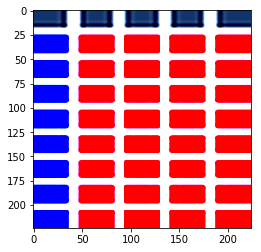

In [13]:
import matplotlib.pyplot as plt
#plt.imshow(transforms.ToPILImage()(dataset_train[200][0]))
plt.imshow(  dataset_train[100][0].permute(1, 2, 0)  )
plt.show()